# Phase Circuit Optimization

Changing working directory from `./notebooks/` to `./`, in order to import the Python packages defined in the repository.

In [1]:
import os
DEBUG = True
try:
    print("Original working directory: %s"%str(original_wd)) # type: ignore
    """
        You only get here if you---by mistake or otherwise---are re-running this cell, 
        in which case the working should not be changed again.
    """
except NameError:
    original_wd = os.getcwd()
    os.chdir('../')
print("Current working directory: %s"%str(os.getcwd()))

Current working directory: C:\Users\Stefa\Documents\git\pauliopt


General purpose imports:

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np
# import qiskit

Some utility code to display HTML elements and images/figures side-by-side:

In [3]:
from io import BytesIO
from typing import Union
from IPython.display import Image, HTML # type: ignore
def figure_to_image(fig: plt.Figure, fmt: str = "png") -> Image:
    """ Converts a Matplotlib figure to a PNG IPython Image. """
    buffer = BytesIO()
    fig.savefig(buffer, format=fmt)
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    return Image(image_png, format=fmt, embed=True)
def side_by_side(*elements: Union[str, Image]) -> HTML:
    """
        Returns an HTML Div element with the given elements
        displayed side by side. Accepts raw HTML code or
        IPython Image objects.
    """
    html = f"<div style='display:flex; align-items: center;'>"
    for el in elements:
        if isinstance(el, str):
            html += el
        elif isinstance(el, Image):
            html += f"<img src='data:image/png;base64,{el._repr_png_()}'/>"
    html += f"</div>"
    return HTML(html)

## Phase Circuit Optimization

The optimized version of a given circuit of mixed ZX phase gadgets takes the form of a **Phase block**, consisting of mixed ZX phase gadgets, conjugated by a **CX block**, consisting of CX gates. If the original circuit is repeated a given number `circuit_rep` of times, then so is the phase block part of the optimized circuit:

<img src="phase_circuit_opt.svg" width=60%/>

Optimization is done through the `OptimizedPhaseCircuit` class. An optimizer is instantiated from:

- the original phase circuit to be optimized;
- a topology, constraining the CX circuit used for the optimization;
- a number of layers to use for the CX block;
- the number `circuit_rep` of times that the original circuit is to be repeated (default: 1);
- optionally, a fixed seed `rng_seed` for the random number generator.

In [4]:
from pauliopt.phase import OptimizedPhaseCircuit

For our running example, we use a 3x3 grid qubit topology:

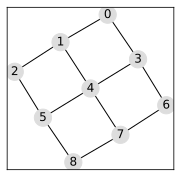

In [5]:
from pauliopt.topologies import Topology
topology = Topology.grid(3, 3)
topology.draw(figsize=(3, 3))

We construct a small random phase circuit on the same qubits:

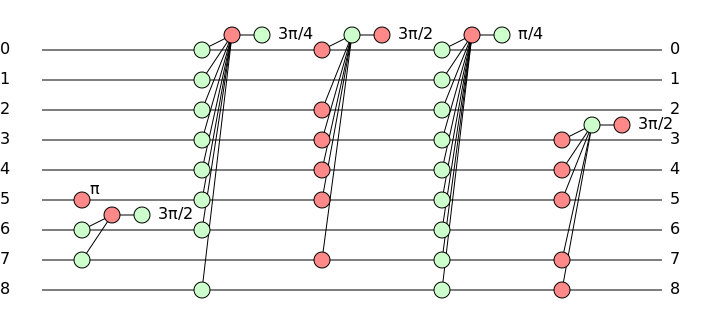

In [6]:
from pauliopt.phase import PhaseCircuit, CXCircuit
orig_circuit = PhaseCircuit.random(topology.num_qubits, 6, rng_seed=0)
orig_circuit

To optimize it, we instantiate an optimizer with a single-layer CX circuit.
The optional parameter `rng_seed` can be used to pass a seed to the RNG.

In [7]:
opt = OptimizedPhaseCircuit(orig_circuit, topology, cx_block=1, rng_seed=0)

The topology and number of qubits are made available through suitably named properties of the optimizer. The original circuit is not saved.

In [8]:
print(f"{opt.num_qubits = }", end="\n\n")
print(f"{opt.topology = }", end="\n\n")

opt.num_qubits = 9

opt.topology = Topology({0, 1, 2, 3, 4, 5, 6, 7, 8}, [{3, 4}, {1, 4}, {1, 2}, {0, 3}, {4, 5}, {0, 1}, {3, 6}, {6, 7}, {2, 5}, {7, 8}, {5, 8}, {4, 7}])



## Phase and CX Blocks

Circuit optimization is progressive. The optimizer makes the current phase block and CX block available (in readonly view) through suitably named properties `phase_block` and `cx_block`.

At the beginning, the phase block is equal to the original circuit.

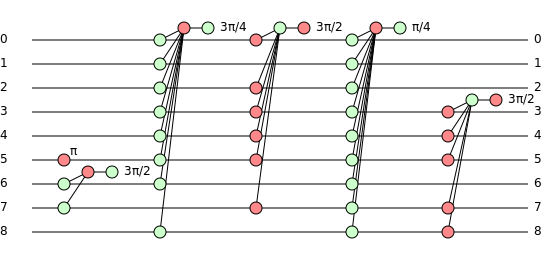

In [9]:
opt.phase_block.to_svg(scale=0.8)

At the beginning, the CX block is empty (given number of layers, no CX gates).

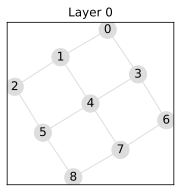

In [10]:
opt.cx_block.draw(figsize=(3, 3))

## Random CX Flips

Optimization is performed by simulated annealing. Random CX gates are flipped in the CX block for a given number of iterations, in an attempt to reduce the complexity of the overall optimized circuit (CX block adjoint + phase block repeated `circuit_rep` times + CX block). The method `OptimizedPhaseCircuit.random_flip_cx()` is used to perform such a random flip: it modifies the internal phase circuit and CX circuit in place, returning information about the layer index and CX gate that was just flipped in case it has to be undone.

The method `OptimizedPhaseCircuit.flip_cx(layer_idx, ctrl, trgt)` is used to perform a specific CX gate flip, while the method `OptimizedPhaseCircuit.is_cx_flippable(layer_idx, ctrl, trgt)` can be used to check if a specific flip can be performed.

Here we see an example with a single random flip:

=== Phase block and CX block before random flip ===


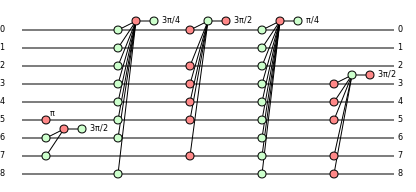

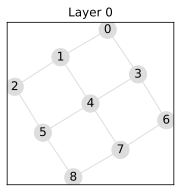



=== Phase block and CX block after flipping gate (8, 5) in layer 0 ===


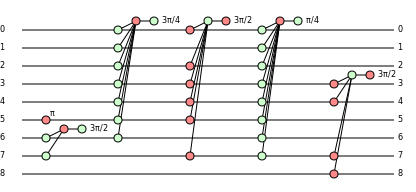

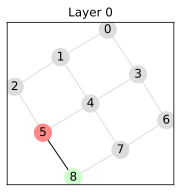

In [11]:
opt = OptimizedPhaseCircuit(orig_circuit, topology, cx_block=1, rng_seed=0)
print("=== Phase block and CX block before random flip ===")
display(opt.phase_block.to_svg(scale=0.6))
opt.cx_block.draw(figsize=(3, 3))
layer_idx, gate = opt.random_flip_cx()
print(f"\n\n=== Phase block and CX block after flipping gate {gate} in layer {layer_idx} ===")
display(opt.phase_block.to_svg(scale=0.6))
opt.cx_block.draw(figsize=(3, 3))

Here we see another example, at the beginning and after 8 random flips:

=== Phase block and CX block before random flip ===


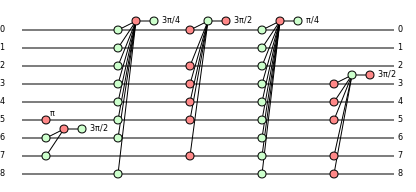

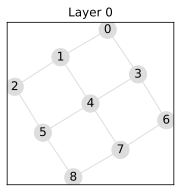



=== Phase block and CX block after 3 random flips ===


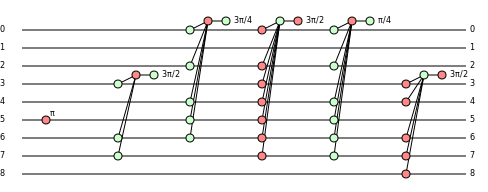

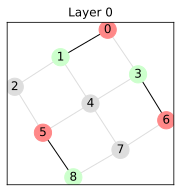

In [12]:
opt = OptimizedPhaseCircuit(orig_circuit, topology, cx_block=1, rng_seed=0)
print("=== Phase block and CX block before random flip ===")
display(opt.phase_block.to_svg(scale=0.6))
opt.cx_block.draw(figsize=(3, 3))
for _ in range(3):
    opt.random_flip_cx()
print(f"\n\n=== Phase block and CX block after 3 random flips ===")
display(opt.phase_block.to_svg(scale=0.6))
opt.cx_block.draw(figsize=(3, 3))

## Annealing - Prelude

Randomly flipping CX gates and hoping for the best is not much good as an optimisation strategy: simulated annealing is used instead as a global optimisation technique.

The method `OptimizedPhaseCircuit.anneal(num_iters, schedule)` allows a given number of iterations of simulated annealing to be performed on the circuit, for a given temperature schedule (default: linear temperature schedule with initial temperature 1.0 and final temperature 0.1).
The method also accepts an optional keyword argument `loggers`, for detailed logging.

## Temperature Schedule

A **temperature schedule** is any function which fits the `TempSchedule` protocol below: given the index `it` of the current iteration an the total number `num_iters` of iterations, it returns the temperature (as a `float`).

In [13]:
from typing import Protocol
class TempSchedule(Protocol):
    """
        Protocol for a temperature schedule.
        The temperature is a number computed from the iteration number `it`
        (starting from 0) and the total number of iterations `num_iter`.
    """

    def __call__(self, it: int, num_iters: int) -> float:
        ...

The library offers 4 utility standard temperature schedules: linear, geometric, reciprocal and logarithmic, each given initial and final temperatures. The schedules are taken from [this paper](https://link.springer.com/article/10.1007/BF00143921).

In [14]:
from pauliopt.utils import (linear_temp_schedule, geometric_temp_schedule, 
                            reciprocal_temp_schedule, log_temp_schedule)

Here is a plot of the four temperature schedules over 1000 iterations, for initial temperature 1 and final temperature 0.1. 

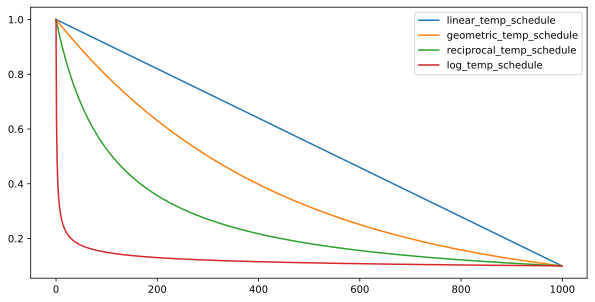

In [15]:
num_iters = 1000
plt.figure(figsize=(10,5))
for temp_schedule_maker in [linear_temp_schedule, geometric_temp_schedule, 
                            reciprocal_temp_schedule, log_temp_schedule]:
    temp_schedule = temp_schedule_maker(t_init=1, t_final=1e-1)
    temp = [temp_schedule(it, num_iters) for it in range(num_iters)]
    plt.plot(range(num_iters), temp, label=temp_schedule_maker.__name__)
plt.legend()
plt.show()

## Energy Function

The energy function used for annealing is the number of nearest-neighbour CX gates used to implement the optimized circuit.
For the CX blocks, this is simply the number of CX gates, because all gates are already nearest-neighbour by construction.
For the phase blocks, the count is preformed by adding up the CX count for a topologically-aware implementation of phase gadgets based on minimum spanning trees (MST).
The CX counts for the original circuit and optimized circuit (both with the desired number `circuit_rep` of repetitions) are exposed by the properties `OptimizedPhaseCircuit.init_cx_count` (for the original circuit) and `OptimizedPhaseCircuit.cx_count` (for the current circuit).

The gadgets themselves have a `PhaseGadget.cx_count(topology)` method to compute the gadget cost for this implementation, and a `PhaseGadget.print_impl_info(topology)` method which prints detailed information about the MST and the CX count for individual branches.

To understand how the cost of a single phase gadget is computed, we consider the following example on a 3x3 grid topology.

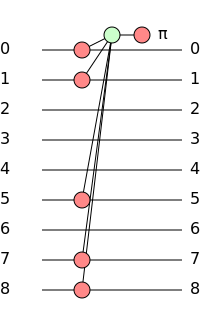

In [16]:
test_circ = PhaseCircuit.random(topology.num_qubits, 1, rng_seed=0)
test_circ

The phase gadget above spans qubits `{0, 1, 5, 7, 8}`. One possible minimal spanning tree implementation involves two mirror ladders of the following CX gates (with a phase gate on qubit 7 in between):

- 1 CX gate between 0 and 1 (dist: 1)
- 3 CX gate between 1 and 5 (dist: 2)
- 1 CX gate between 5 and 8 (dist: 1)
- 1 CX gate between 8 and 7 (dist: 1)

Each ladder has 6 CX gates, so the total CX count for the phase gadget is 12.

In [17]:
test_gadget = test_circ.gadgets[0]
test_gadget.print_impl_info(topology)

MST implementation info for X(π) @ {0, 1, 5, 7, 8}:
  - Overall CX count for gadget: 12
  - MST branches: [(0, 1), (1, 5), (5, 8), (8, 7)]
  - CX counts for MST branches: [2, 8, 10, 12]



Let's now consider a second example:

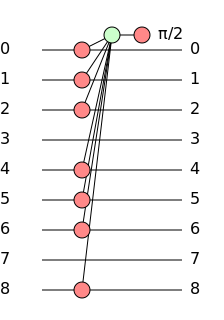

In [18]:
test_circ = PhaseCircuit.random(topology.num_qubits, 1, rng_seed=1)
test_circ

The phase gadget above spans qubits `{0, 1, 2, 4, 5, 6, 8}`. One possible minimal spanning tree implementation involves two mirror ladders of the following CX gates (with a phase gate on qubit 7 in between):

- 1 CX gate between 0 and 1 (dist: 1)
- 1 CX gate between 1 and 2 (dist: 1)
- 1 CX gate between 1 and 4 (dist: 1)
- 1 CX gate between 2 and 5 (dist: 1)
- 1 CX gate between 5 and 8 (dist: 1)
- 3 CX gates between 0 and 6 (dist: 2)

Each ladder has 8 CX gates, so the total CX count for the phase gadget is 16.

In [19]:
test_gadget = test_circ.gadgets[0]
test_gadget.print_impl_info(topology)

MST implementation info for X(π/2) @ {0, 1, 2, 4, 5, 6, 8}:
  - Overall CX count for gadget: 16
  - MST branches: [(0, 1), (1, 2), (1, 4), (2, 5), (5, 8), (0, 6)]
  - CX counts for MST branches: [2, 4, 6, 8, 10, 16]



Now let's look at an example of cost reduction in a circuit with several phase gadgets.
Consider the example from before:

CX count before flip: 50
  - Gadget CX counts: [0, 2, 14, 10, 16, 8]
  - CX count for the CX blocks: 0


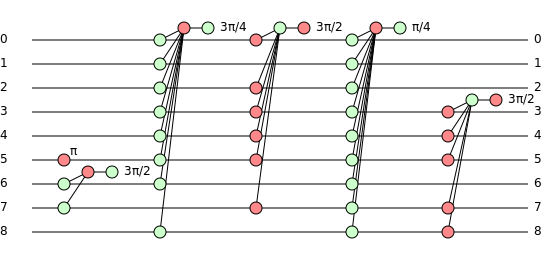

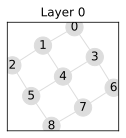

In [20]:
opt = OptimizedPhaseCircuit(orig_circuit, topology, 1, rng_seed=1)
print(f"CX count before flip: {opt.init_cx_count}")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in opt.phase_block.gadgets]}")
print(f"  - CX count for the CX blocks: {2*opt.cx_block.num_gates}")
display(opt.phase_block.to_svg(scale=0.8))
opt.cx_block.draw(figsize=(2, 2))

If we conjugate the circuit by a CX gate with control 0 and target 1, the cost changes as follows:

- we remove 4 CX gates from the phase block (3rd and 5th phase gadgets lose a leg);
- we add 2 CX gates to the CX blocks;

Overall, the cost is reduced by 2. It would be reduced by `4*circuit_rep-2` in the general case.

CX count after flip: 50
  - Gadget CX counts: [0, 2, 12, 10, 14, 8]
  - CX count for the CX blocks: 2


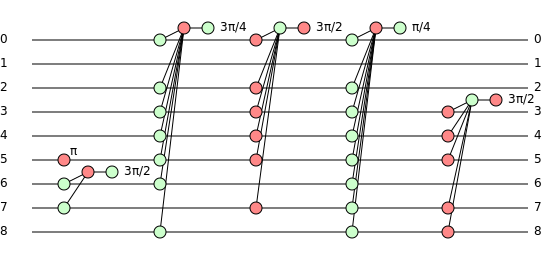

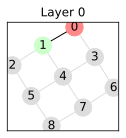

In [21]:
opt.flip_cx(0, 1, 0)
print(f"CX count after flip: {opt.cx_count}")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in opt.phase_block.gadgets]}")
print(f"  - CX count for the CX blocks: {2*opt.cx_block.num_gates}")
display(opt.phase_block.to_svg(scale=0.8))
opt.cx_block.draw(figsize=(2, 2))

If we further conjugate the circuit by a CX gate with control 2 and target 5, the cost changes as follows:

- we remove 4 CX gates from the phase block (3rd and 5th phase gadget lose a leg);
- we add 2 CX gates to the phase block (4th phase gadget gains a leg);
- we add 2 CX gates to the CX blocks;

Overall, the cost is reduced by 0. It would be reduced by `2*circuit_rep-2` in the general case.

CX count after second flip: 50
  - Gadget CX counts: [0, 2, 10, 12, 12, 8]
  - CX count for the CX blocks: 4


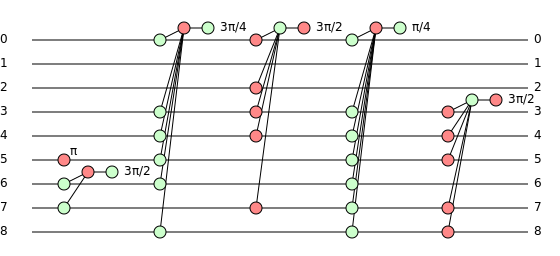

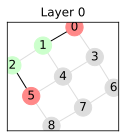

In [22]:
opt.flip_cx(0, 2, 5)
print(f"CX count after second flip: {opt.cx_count}")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in opt.phase_block.gadgets]}")
print(f"  - CX count for the CX blocks: {2*opt.cx_block.num_gates}")
display(opt.phase_block.to_svg(scale=0.8))
opt.cx_block.draw(figsize=(2, 2))

## Annealing

The method `OptimizedPhaseCircuit.anneal(num_iters, schedule)` allows a given number of iterations of simulated annealing to be performed on the circuit, for a given temperature schedule.

The method also accepts an optional keyword argument `loggers`, for detailed logging.

In [23]:
from math import log10, ceil
def log_iter(it, prev_cost, new_cost, accepted, flip, t, num_iters):
    if new_cost < prev_cost:
        print(f"Iter #{it:>0{ceil(log10(num_iters-1))}}, new cost: {new_cost}")
loggers = {
    "log_start": lambda cost, num_iters: print(f"Init cost: {cost}"),
    "log_iter": log_iter,
    "log_end": lambda cost, num_iters: print(f"Final cost: {cost}"),
}

As our first example, we anneal for 100 iterations on a geometric temperature schedule, from an initial temperature of 1 to a final temperature of 1e-5.
The circuit consists of 6 phase gadgets on a 3x3 qubit grid.
The cost function is based on the circuit not being repeated (`circuit_rep=1`).
We use a single-layer CX block.

In [24]:
topology = Topology.grid(3, 3)
circuit = PhaseCircuit.random(topology.num_qubits, 6, rng_seed=0)
opt = OptimizedPhaseCircuit(circuit, topology, cx_block=1, circuit_rep=1, rng_seed=1)
opt.anneal(100, schedule=("geometric", 1, 1e-5), loggers=loggers)

Init cost: 50
Iter #04, new cost: 48
Iter #12, new cost: 46
Iter #13, new cost: 44
Iter #35, new cost: 42
Final cost: 42


After annealing, the cost has been reduced by 16%: the improvements in gadget CX counts are somewhat offset by the CX count of the CX blocks. In the limit of a large number of repetitions of the original circuit, the cost would be reduced by up to 28%.

CX count before annealing: 50
  - Gadget CX counts: [0, 2, 14, 10, 16, 8]

Cost after annealing: 42 (1 reps: -16.0%, many reps limit: -28.0%)
  - Gadget CX counts: [0, 2, 8, 10, 10, 6]
  - CX blocks CX count: 6


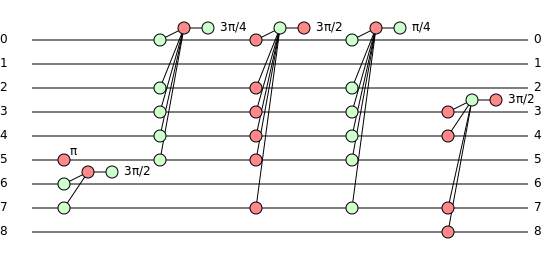

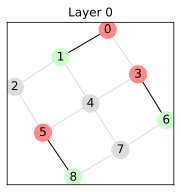

In [25]:
print(f"CX count before annealing: {opt.init_cx_count}")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in circuit.gadgets]}")
print()
change = (opt.cx_count-opt.init_cx_count)/opt.init_cx_count
max_change = (opt.cx_count-opt.init_cx_count-2*opt.cx_block.num_gates)/opt.init_cx_count
print(f"Cost after annealing: {opt.cx_count} "
      f"({opt.circuit_rep} reps: {change:.1%}, many reps limit: {max_change:.1%})")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in opt.phase_block.gadgets]}")
print(f"  - CX blocks CX count: {2*opt.cx_block.num_gates}")
display(opt.phase_block.to_svg(scale=0.8))
opt.cx_block.draw(figsize=(3, 3))

As our second example, we anneal for 1000 iterations on the same schedule. Circuit and number of repetitions as before. However, this time we use a 4-layer CX block.

In [26]:
topology = Topology.grid(3, 3)
circuit = PhaseCircuit.random(topology.num_qubits, 6, rng_seed=0)
opt = OptimizedPhaseCircuit(circuit, topology, cx_block=4, circuit_rep=1, rng_seed=1)
opt.anneal(1000, schedule=("geometric", 1, 1e-5), loggers=loggers)

Init cost: 50
Iter #000, new cost: 48
Iter #003, new cost: 46
Iter #090, new cost: 42
Iter #112, new cost: 38
Iter #159, new cost: 34
Iter #179, new cost: 32
Final cost: 32


After annealing, the cost has been reduced by 36%. In the limit of a large number of repetitions of the original circuit, the cost would be reduced by up to 60%.

CX count before annealing: 50
  - Gadget CX counts: [0, 2, 14, 10, 16, 8]


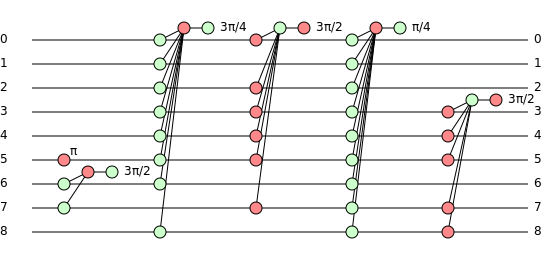

Cost after annealing: 32 (1 reps: -36.0%, many reps limit: -60.0%)
  - Gadget CX counts: [0, 0, 2, 8, 4, 6]
  - CX blocks CX count: 12


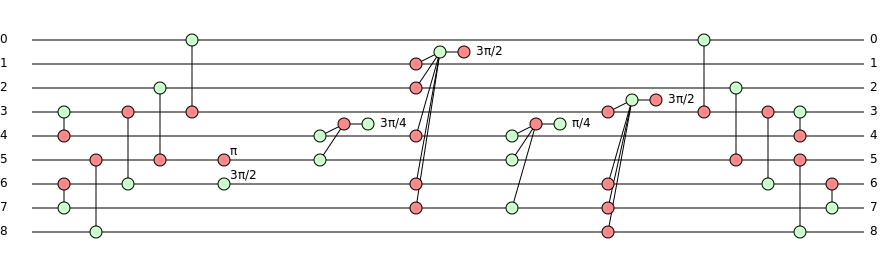

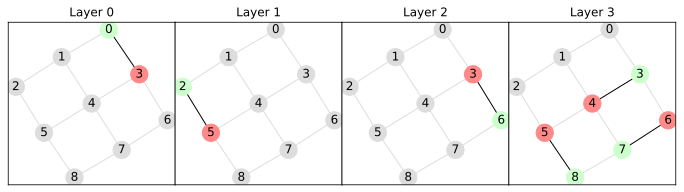

In [27]:
print(f"CX count before annealing: {opt.init_cx_count}")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in circuit.gadgets]}")
display(circuit.to_svg(scale=0.8))
change = (opt.cx_count-opt.init_cx_count)/opt.init_cx_count
max_change = (opt.cx_count-opt.init_cx_count-2*opt.cx_block.num_gates)/opt.init_cx_count
print(f"Cost after annealing: {opt.cx_count} "
      f"({opt.circuit_rep} reps: {change:.1%}, many reps limit: {max_change:.1%})")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in opt.phase_block.gadgets]}")
print(f"  - CX blocks CX count: {2*opt.cx_block.num_gates}")
display(opt.to_svg(scale=0.8))
opt.cx_block.draw(figsize=(3, 3))

As an example, we look at the effect on 3 repetitions of the circuit, where annealing achieves a 48% reduction in CX count:

CX count before annealing: 150


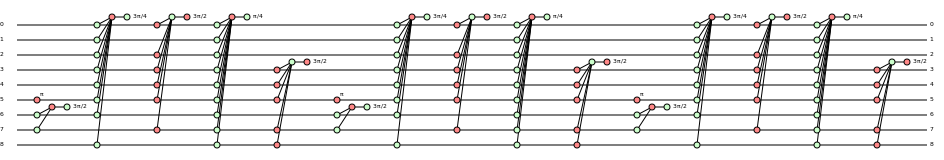

CX count after annealing: 78 (3 reps: -48.0%)


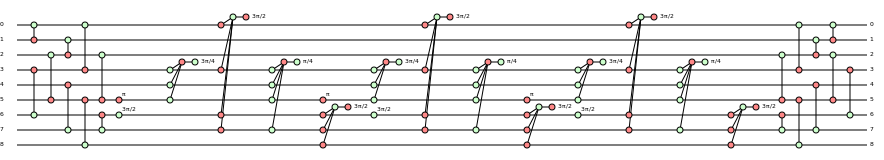

In [28]:
circuit_3 = circuit >> circuit >> circuit
opt_3 = OptimizedPhaseCircuit(circuit, topology, cx_block=3, circuit_rep=3, rng_seed=4)
print(f"CX count before annealing: {opt_3.init_cx_count}")
display(circuit_3.to_svg(scale=0.5))
opt_3.anneal(1000, schedule=("geometric", 1, 1e-5))
change_3 = (opt_3.cx_count-opt_3.init_cx_count)/opt_3.init_cx_count
print(f"CX count after annealing: {opt_3.cx_count} ({opt_3.circuit_rep} reps: {change_3:.1%})")
display(opt_3.to_svg(hscale=0.42, vscale=0.5))

As our final example, we anneal for 1000 iterations on a linear temperature schedule, from an initial temperature of 1 to a final temperature of 1e-5.
The circuit consists of 50 phase gadgets on a 5x5 qubit grid, with a number of legs between 1 and 3.
The cost function is based on the circuit being repeated 5 times (`circuit_rep=5`).
We use a 3-layer CX block.

In [29]:
topology = Topology.grid(5, 5)
circuit = PhaseCircuit.random(topology.num_qubits, 50, min_legs=1, max_legs=3, rng_seed=0)
opt = OptimizedPhaseCircuit(circuit, topology, cx_block=3, circuit_rep=5, rng_seed=1)
opt.anneal(1000, schedule=("linear", 1, 1e-5), loggers=loggers)

Init cost: 2750
Iter #000, new cost: 2672
Iter #002, new cost: 2644
Iter #003, new cost: 2636
Iter #012, new cost: 2628
Iter #014, new cost: 2620
Iter #015, new cost: 2612
Iter #017, new cost: 2594
Iter #021, new cost: 2586
Iter #023, new cost: 2568
Iter #027, new cost: 2550
Iter #034, new cost: 2538
Iter #040, new cost: 2490
Iter #073, new cost: 2462
Iter #094, new cost: 2420
Iter #105, new cost: 2402
Iter #125, new cost: 2394
Iter #131, new cost: 2376
Iter #154, new cost: 2368
Iter #177, new cost: 2340
Iter #189, new cost: 2292
Iter #298, new cost: 2276
Iter #326, new cost: 2276
Iter #327, new cost: 2274
Iter #349, new cost: 2272
Iter #674, new cost: 2272
Final cost: 2272


After annealing, the cost has been reduced by 23.6% for 5 repetitions of the original circuit, close the 24.8% saving that could be obtained in the limit of a large number of repetitions of the original circuit.

CX count before annealing: 2750
  - Gadget CX counts: [10, 14, 20, 24, 24, 18, 20, 12, 18, 12, 20, 16, 6, 28, 0, 10, 20, 12, 22, 10, 0, 14, 6, 28, 24, 0, 16, 2, 6, 16, 2, 0, 0, 12, 6, 14, 6, 8, 10, 0, 24, 0, 0, 24, 14, 0, 0, 2, 20, 10]

Cost after annealing: 2272 (5 reps: -17.4%, many reps limit: -18.5%)
  - Gadget CX counts: [8, 12, 12, 20, 18, 16, 20, 6, 18, 12, 18, 14, 4, 14, 0, 4, 20, 12, 24, 6, 2, 14, 4, 28, 12, 0, 16, 0, 4, 12, 0, 0, 0, 8, 8, 12, 10, 6, 6, 0, 18, 0, 0, 20, 14, 0, 2, 2, 16, 8]
  - CX blocks CX count: 32


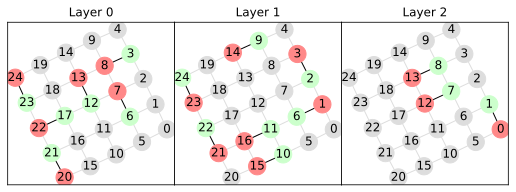

In [30]:
print(f"CX count before annealing: {opt.init_cx_count}")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in circuit.gadgets]}")
print()
change = (opt.cx_count-opt.init_cx_count)/opt.init_cx_count
max_change = (opt.cx_count-opt.init_cx_count-2*opt.cx_block.num_gates)/opt.init_cx_count
print(f"Cost after annealing: {opt.cx_count} "
      f"({opt.circuit_rep} reps: {change:.1%}, many reps limit: {max_change:.1%})")
print(f"  - Gadget CX counts: {[g.cx_count(topology) for g in opt.phase_block.gadgets]}")
print(f"  - CX blocks CX count: {2*opt.cx_block.num_gates}")
opt.cx_block.draw(figsize=(3, 3))

We can use the loggers to perform some basic performance benchmarking of our annealing algorithm.

In [31]:
from time import perf_counter
iter_timestamps = []
def log_start_time(cost, num_iters):
    del iter_timestamps[:]
    iter_timestamps.append(perf_counter())
def log_iter_time(it, prev_cost, new_cost, accepted, flip, t, num_iters):
    iter_timestamps.append(perf_counter())
def log_end_time(cost, num_iters):
    a = np.array(iter_timestamps)
    iter_times = 1_000_000*(a[1:]-a[:-1]) # in μs
    avg_iter_time = np.mean(iter_times)
    iter_time_std = np.std(iter_times)
    print(f"Average iter time: {avg_iter_time:.0f} μs "
          f"({avg_iter_time/circuit.num_gadgets:.0f} μs/gadget)")
    print(f"Iter time std dev: {iter_time_std:.0f} μs")
time_loggers = {
    "log_start": log_start_time,
    "log_iter": log_iter_time,
    "log_end": log_end_time,
}

We first consider a small 9-qubit circuit.

In [32]:
topology = Topology.grid(3, 3)
circuit = PhaseCircuit.random(topology.num_qubits, 50, min_legs=1, max_legs=3, rng_seed=0)
opt = OptimizedPhaseCircuit(circuit, topology, cx_block=4, circuit_rep=1, rng_seed=1)
opt.anneal(100, schedule=("geometric", 1, 1e-5), loggers=time_loggers)

Average iter time: 1284 μs (26 μs/gadget)
Iter time std dev: 1675 μs


We then consider a larger 36-qubit circuit.

In [33]:
topology = Topology.grid(5, 5)
circuit = PhaseCircuit.random(topology.num_qubits, 50, min_legs=1, max_legs=3, rng_seed=0)
opt = OptimizedPhaseCircuit(circuit, topology, cx_block=4, circuit_rep=1, rng_seed=1)
opt.anneal(100, schedule=("linear", 1, 1e-5), loggers=time_loggers)

Average iter time: 1127 μs (23 μs/gadget)
Iter time std dev: 618 μs


We then consider a large 81-qubit circuit.

In [34]:
topology = Topology.grid(9, 9)
circuit = PhaseCircuit.random(topology.num_qubits, 50, min_legs=1, max_legs=3, rng_seed=0)
opt = OptimizedPhaseCircuit(circuit, topology, cx_block=4, circuit_rep=1, rng_seed=0)
opt.anneal(100, schedule=("linear", 1, 1e-5), loggers=time_loggers)

Average iter time: 1428 μs (29 μs/gadget)
Iter time std dev: 1301 μs


Finally, we consider a very large 144-qubit circuit.

In [35]:
topology = Topology.grid(12, 12)
circuit = PhaseCircuit.random(topology.num_qubits, 50, min_legs=1, max_legs=3, rng_seed=0)
opt = OptimizedPhaseCircuit(circuit, topology, cx_block=4, circuit_rep=1, rng_seed=0)
opt.anneal(10, schedule=("linear", 1, 1e-5), loggers=time_loggers)

Average iter time: 2384 μs (48 μs/gadget)
Iter time std dev: 1836 μs
